In [1]:
import sys
import os

cwd = os.getcwd()
h, _ = os.path.split(cwd)

sys.path.append(h)

from scripts import viz, metrics
from scripts.metrics import DetectionMetrics
from datetime import datetime

DATE = datetime.today().strftime('%d.%m_%H.%M')
IAD_RESULTS_FOLDER = f"idealized/{DATE}"

iad_metrics_dir = os.path.join(os.getcwd(), f'{IAD_RESULTS_FOLDER}/metrics')
iad_classifier_dir = os.path.join(os.getcwd(), f'{IAD_RESULTS_FOLDER}/classifiers')

os.makedirs(iad_metrics_dir, exist_ok=True)
os.makedirs(iad_classifier_dir, exist_ok=True)

print(DATE)

09.06_20.16


In [2]:
# const
n_runs = 3
n_epochs = 100
batch_size = 128

# Test Data

In [3]:
import numpy as np
import pandas as pd

SR_test = pd.read_csv("../data/evaluation/SR_test.csv")
extrabg_SR_test = pd.read_csv("../data/evaluation/extrabg_SR_test.csv")

SR_test.shape, extrabg_SR_test.shape

((60000, 6), (300000, 6))

Здесь мы **оставляем** тестовые данные как есть, просто потому что `preds_from_model` так хочет.

In [4]:
test_data = pd.concat([SR_test, extrabg_SR_test]).to_numpy()
test_target = test_data[:, -1]

test_data = test_data
test_data.shape

(360000, 6)

In [5]:
test_target.mean()

0.05555555555555555

# Functional

In [6]:
from scripts.nn_classifier import get_loaders
from sklearn.preprocessing import StandardScaler
from scripts.nn_classifier import train_classifier
from scripts.nn_classifier import preds_from_model


def get_preds(data_train, model_paths, clf_dir):
    clf_dir = os.path.join(os.getcwd(), clf_dir)
    sc = StandardScaler().fit(data_train)
    preds_matrix = preds_from_model(test_data, sc, model_paths, save_dir=clf_dir)
    return preds_matrix

# Idealized AD

For the idealized anomaly detector mock SR data (60k) and simulation SR background (136k) are used

In [7]:
sr_train = pd.read_csv("../data/mock/SR_train.csv")
bkg_train = pd.read_csv("../data/simulation/extrabg_SR_train.csv")
sr_valid = pd.read_csv("../data/mock/SR_val.csv")
bkg_valid = pd.read_csv("../data/simulation/extrabg_SR_val.csv")

sr_train.shape, bkg_train.shape, sr_valid.shape, bkg_valid.shape

((60000, 6), (136429, 6), (60000, 6), (136429, 6))

Данные с префиксом `SR` помечаем как `data`, с префиксом `bkg` -- `perfectly simulated`.

In [8]:
def add_column(arr, val):
    z = np.full((arr.shape[0], 1), val)
    return np.append(arr, z, axis=1)

# Последний столбец удаляется -- не используем его
sr_train_np = add_column(sr_train.to_numpy()[:, 1:-1], 1.0)
bkg_train_np = add_column(bkg_train.to_numpy()[:, 1:-1], 0.0)

sr_valid_np = add_column(sr_valid.to_numpy()[:, 1:-1], 1.0)
bkg_valid_np = add_column(bkg_valid.to_numpy()[:, 1:-1], 0.0)

In [9]:
sr_train_np.shape, bkg_train_np.shape

((60000, 5), (136429, 5))

In [10]:
train_iad_data = np.vstack([sr_train_np, bkg_train_np])
valid_iad_data = np.vstack([sr_valid_np, bkg_valid_np])

train_iad_target = train_iad_data[:, -1]
valid_iad_target = valid_iad_data[:, -1]

train_iad_data = train_iad_data[:, :-1]
valid_iad_data = valid_iad_data[:, :-1]

train_iad_data.shape, valid_iad_data.shape

((196429, 4), (196429, 4))

## NN

### Train

In [11]:
loaders, class_weight = get_loaders(train_iad_data, train_iad_target, valid_iad_data, valid_iad_target)
# class_weight = None
model_paths = train_classifier(loaders, class_weight, iad_classifier_dir, n_epochs, n_runs)

class_weight: [0.7198946  1.63690833]
Run 1...


epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Run 2...


epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Run 3...


epoch:   0%|          | 0/100 [00:00<?, ?it/s]

10
Run 1 minimum validation loss epochs: [10 20 28 13 24 12 21 26 15 17]
Run 2 minimum validation loss epochs: [12 13 26 22 21 18 16 15 27 38]
Run 3 minimum validation loss epochs: [21 14 23 22 15  9 17 18 10 13]


### Preds

In [12]:
sc = StandardScaler().fit(train_iad_data)
iad_preds = preds_from_model(test_data, sc, model_paths, save_dir=iad_classifier_dir)

### Metrics

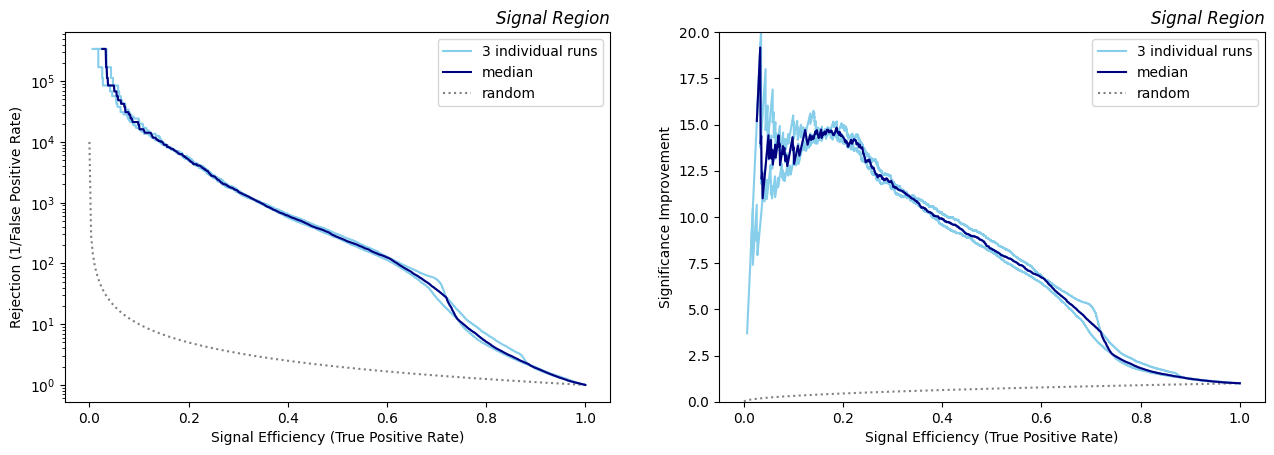

,AUC-ROC,AUC-PR,AUC-SIC
run 1,0.874873,0.699402,7.486140
run 2,0.884280,0.706556,8.002899
run 3,0.878333,0.690337,7.559885


In [13]:
det_metrics = DetectionMetrics()
det_metrics.show(iad_preds, test_target, save_dir=iad_metrics_dir)